# 5.1. Задача убедиться в том, что наша система сплитования работает корректно, и ключевая метрика не отличается между группами в нашем АА-тесте.
У нас eсть данные АА-теста с '2022-09-26' по '2022-10-02' из 2 и 3 экспериментальной группы<br>
<br>
Что нужно сделать:   
1. нужно сделать симуляцию, как будто мы провели 10000 АА-тестов.<br> 
* Бутстреп<br> 
* Бакетное преобразоование  <br> 
2. На каждой итерации нужно сформировать подвыборки без повторения в 500 юзеров <br>
3. Провести сравнение этих подвыборок t-testом.<br>
4. Построить гистограмму распределения получившихся 10000 p-values.<br>
4. Посчитать, какой процент p-values оказался меньше либо равен 0.05<br>
6. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

In [1]:
import pandahouse as ph
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import stats

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20221020',
              'user':'student', 
              'password':'dpo_python_2020'
             }

In [3]:
# выгружаю данные из clickhouse в датафрейм по группе 2 и 3 за период с '2022-09-26' по '2022-10-02'
q = '''
SELECT  exp_group, 
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        (likes / views) as ctr
FROM {db}.feed_actions
WHERE toDate(time) BETWEEN '2022-09-26' and '2022-10-02' 
      AND exp_group in (2,3)
GROUP BY exp_group, user_id      
'''

df = ph.read_clickhouse(q, connection = connection)

In [4]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


### 5.1.1. Проверяем (в целом) корректно ли разбиты пользователи на группы
Если пользователи разбиты корректно, должно выполняться два условия:  <br>
1.1. размеры групп должны быть примерно одинаковые<br> 
1.2. показатели в них самих сами по себе не должны различаться  <br>

In [5]:
# 1.1.смотрю количество пользователей в каждой группе - размеры групп примерно одинаковые  
# 1.2. средние значения CTR также приблизительно одинаковые  - различия в третьем знаке после запятой
df.groupby('exp_group', as_index = False).agg({'ctr': ['count', 'mean']})

exp_group   ctr          
            count      mean
0         2  8480  0.218246
1         3  8569  0.219161

In [6]:
# 1.2. строим график ctr в целом для двух групп, 
# чтобы сначала сравнить в целом не различаются ли показатели ctr в двух группах

#делаем график в seaborn покрупнее
sns.set(rc={'figure.figsize': (12, 9)})

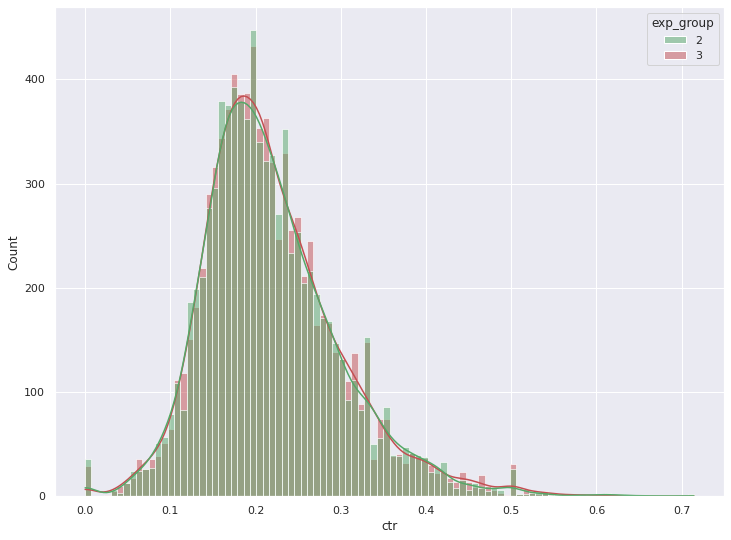

In [7]:
groups = sns.histplot(data = df,
                     x = 'ctr', 
                     hue = 'exp_group',
                     palette = ['g', 'r'],
                     alpha = 0.5,
                     kde = True) 

# на глаз кажется, что в целом распределение ctr в двух выборках похоже

In [8]:
# проверяю, чтобы один и тот же id не попал в разные группы 

print('Всего пользователей в обеих группах: ', df.user_id.count())
print()
df.uniq = df.groupby('user_id')['exp_group'].nunique().reset_index()
df.uniq.groupby('exp_group').user_id.count()

# каждый id попал только в 1 группу

Всего пользователей в обеих группах:  17049



/tmp/ipykernel_238/1682808531.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.uniq = df.groupby('user_id')['exp_group'].nunique().reset_index()


exp_group
1    17049
Name: user_id, dtype: int64

### 5.1.2. Делаю симуляцию, как будто мы провели 10000 АА-тестов с помощью бутстреп

БУТСТРЕП - план действий: 
1. сформировать 10 тыс подвыборок без повторения в 500 юзеров для каждой выборки (2,3)
2. Провести сравнение этих подвыборок t-testом
3. Построить гистограмму распределения получившихся 10000 p-values

4. Посчитать, какой процент p-values оказался меньше либо равен 0.05. <br>
проверить гипотезы:  <br>
Н0: средний CTR в группе 2 = средниему CTR в группе 3  <br>
Н1: средний CTR в группе 2 != средний CTR в группе 3 (т.е. p-value < 0.05) <br>

5. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

In [9]:
p_count = 0 # счетчик, какой % p-value меньше либо равен 0.05 
n = 10000 #количество подвыборок 
result = [] #сохраняем pvalue в список

for _ in range(n): # количество подвыборок = 10 тыс + столько же раз считаем p-value    
    
    #считаю pvalue в подвыборках
    pvalue = stats.ttest_ind( df[df.exp_group == 2].ctr.sample(500, replace = False), 
                             df[df.exp_group == 3].ctr.sample(500, replace = False),
                             equal_var = False)
  
    result.append(pvalue[1])
    
    #считаю сколько раз p-values оказался меньше либо равен 0.05
    if pvalue[1] <= 0.05:
        p_count += 1
          
print('В ', p_count / n * 100, '% случаев p-values оказался меньше либо равен 0.05')
#print(result)

В  4.54 % случаев p-values оказался меньше либо равен 0.05


In [10]:
# сохранила результаты полученных pvalues в датафрейм
df_pvalues = pd.DataFrame(result, columns = ['pvalue'])
df_pvalues.head()

,pvalue
0,0.940848
1,0.963924
2,0.743654
3,0.605741
4,0.981025


<AxesSubplot:ylabel='Count'>

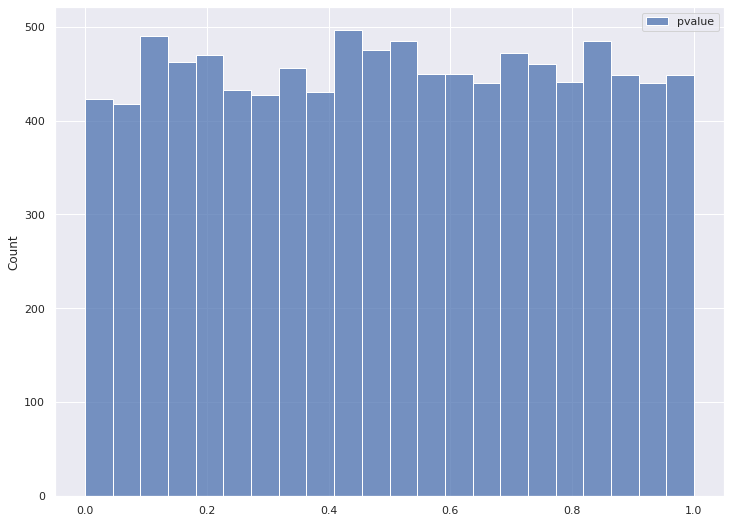

In [11]:
# строим график в seaborn рассчитанных p-values
sns.histplot(df_pvalues, kde = False)

# распределение рассчитанных p-values похоже на равномерное
# на гистограмме видно, что из 10 тыс раз p-values оказался меньше либо равен 0.05 менее чем 500 раз
# не пищу понкретную цифру, тк каждый раз при запуске ячейки с бутсрепом и рассчетом p-values, 
# количество меняется, но при этом никогда не превышает 5%

### Вывод по результатам АА теста: наша система сплитования работает корректно.  <br>
Группы, на которые мы побили пользователей (а именно 2 и 3), еще до того, как не выкатили на них новую функциональность, не отличаются друг от друга, а именно: <br>
1. размеры групп примерно одинаковые  
2. менее чем в 5% случаев p-values оказался меньше либо равен 0.05. 
Т.е. из 10000 АА-тестов, проведенных путем формирования подвыборок без повторения в 500 юзеров из 2 и 3 экспериментальной группы, тест прокрасился менее чем в 5% случаев. Поэтому считаю, что показатели CTR в контрольной и тестовой группах не различаются.<br><br>

Система сплитования работает корректно.